In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

This notebook compute 3 performance metrics (NSE, PBIAS and correlation) for given datasets and a selection of basins. Part 1 selects the basin, the datasets and run through all of them while saving results. Part 2 plots results.

<div class="alert alert-block alert-info">
There is no need to run Part 1, results are already saved. You can jump to part 2 to plot performance tables.
</div>

# 1. Compute performance matrices for selected datasets and basins

We select the basins we want to study. `NB_RUNOFF` is the number of runoff stations from [GRDC](https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/grdc_stations_ftp.html) operating at least 1 year between 2003 and 2017, inside each basin.

In [2]:
basins=load_basins_data()

In [3]:
selected_basins=basins.copy()
Nbasins=selected_basins.shape[0]

print("There are {} basins in the selection:".format(Nbasins))
for clim in np.unique(selected_basins['CLIMATE']):
    print(str(selected_basins.loc[selected_basins['CLIMATE']==clim].shape[0])+' in climate zone '+str(clim))

There are 194 basins in the selection:
48 in climate zone 4
40 in climate zone 8
18 in climate zone 10
44 in climate zone 13
44 in climate zone 16


We plot selected_basins

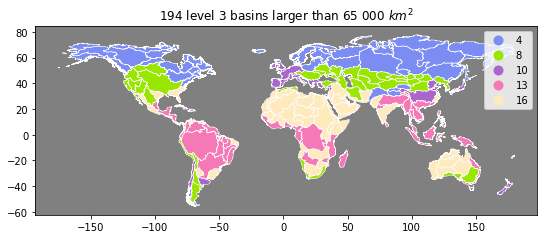

In [5]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_aspect('equal')
basins.plot(ax=ax,edgecolor='white',linewidth=0.5,column='CLIMATE',categorical=True,
            cmap=ListedColormap([climate_colors[i-1] for i in np.unique(basins['CLIMATE'])]),
                  legend=True)
ax.set_facecolor("grey")
ax.set_title('{} level 3 basins larger than 65 000 $km^2$'.format(basins.shape[0]))
plt.show()

List of datasets available for each hydrological variable

In [4]:
list_data_P=['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
              'GLDAS22_CLSM25',
              'MERRA2','MOD16','SSEBop']
list_data_R=['ERA5_Land','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
             'GLDAS22_CLSM25',
             'GRUN','MERRA2']
#list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid','GRACE_ITSG_grid']
data_TWS='GRACE_JPL_mascons'

## Computation for all hydrological datasets, over selected basins + performance metrics saved

Is it the first time we run the code with these parameters ?

In [5]:
first_time=True

We initialize the results dataframe

In [6]:
datasets=[]
for d_P in list_data_P:
    for d_ET in list_data_ET:
        for d_R in list_data_R:
            datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))

In [7]:
len(datasets)

1080

In [8]:
if first_time: 
    Ndatasets=0
    df=selected_basins.copy()
    df[datasets]=np.nan*np.ones((selected_basins.shape[0],len(datasets)))
    correlation_tab=df.copy()
    PBIAS_tab=df.copy()
    NSE_tab=df.copy()
    RMSE_tab=df.copy()    
else: # if we want to add new datasets to existing tabs
    Ndatasets=810
    correlation_tab=pd.read_csv("../results/water_budget/correlation_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])
    PBIAS_tab=pd.read_csv("../results/water_budget/PBIAS_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])
    NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])  
    RMSE_tab=pd.read_csv("../results/water_budget/RMSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])    

In order to compare datasets coherently, the analysis is restricted to the period 2003-2014 where all datasets are available. 

In [9]:
time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]

For each dataset, we load the basin timeseries computed by the notebook `Save basins data`, compute the net accumulation and calculate performance metrics. Each performance is saved in the corresponding table.

In [10]:
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

i=0
for data_P in list_data_P:  
    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])
    
    for data_ET in list_data_ET:   
        ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
        time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])
        
        for data_R in list_data_R:   
            R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
            time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 
            
            i+=1
            print("dataset {}/{}".format(i,len(datasets)))

            for basin_name in selected_basins.index:
                P_filter=P_month.loc[basin_name,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
                ET_filter=ET_month.loc[basin_name,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
                R_filter=R_month.loc[basin_name,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
                TWSC_filter=TWS_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

                fillingP=(np.sum(np.isnan(P_filter))==0)
                fillingET=(np.sum(np.isnan(ET_filter))==0)
                fillingR=(np.sum(np.isnan(R_filter))==0)
                fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

                if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
                    A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
                    TWSC_filter.index=time_idx
                    
                    # compute performance metrics
                    col='P_{}_ET_{}_R_{}_TWS_{}'.format(data_P,data_ET,data_R,data_TWS)
                    
                    corr=A_filter.corr(TWSC_filter)
                    correlation_tab.loc[basin_name,col]=corr

                    PBIAS=percentage_bias(A_filter,TWSC_filter)
                    PBIAS_tab.loc[basin_name,col]=PBIAS

                    NSE=compute_NSE(A_filter,TWSC_filter)
                    NSE_tab.loc[basin_name,col]=NSE
                    
                    RMSE=compute_RMSE(A_filter,TWSC_filter)
                    RMSE_tab.loc[basin_name,col]=RMSE

# sort datasets by alphabetic order before saving
datasets=correlation_tab.columns[np.where(correlation_tab.columns.str[:2]=='P_')]
no_datasets=correlation_tab.columns[np.where(correlation_tab.columns.str[:2]!='P_')]
correlation_tab2=correlation_tab[no_datasets].join(correlation_tab[datasets.sort_values()])
PBIAS_tab2=PBIAS_tab[no_datasets].join(PBIAS_tab[datasets.sort_values()])
NSE_tab2=NSE_tab[no_datasets].join(NSE_tab[datasets.sort_values()])
RMSE_tab2=RMSE_tab[no_datasets].join(RMSE_tab[datasets.sort_values()])
                
correlation_tab2.to_csv("../results/water_budget/correlation_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
PBIAS_tab2.to_csv("../results/water_budget/PBIAS_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
NSE_tab2.to_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
RMSE_tab2.to_csv("../results/water_budget/RMSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
first_time=False

dataset 1/1080
dataset 2/1080
dataset 3/1080
dataset 4/1080
dataset 5/1080
dataset 6/1080
dataset 7/1080
dataset 8/1080
dataset 9/1080
dataset 10/1080
dataset 11/1080
dataset 12/1080
dataset 13/1080
dataset 14/1080
dataset 15/1080
dataset 16/1080
dataset 17/1080
dataset 18/1080
dataset 19/1080
dataset 20/1080
dataset 21/1080
dataset 22/1080
dataset 23/1080
dataset 24/1080
dataset 25/1080
dataset 26/1080
dataset 27/1080
dataset 28/1080
dataset 29/1080
dataset 30/1080
dataset 31/1080
dataset 32/1080
dataset 33/1080
dataset 34/1080
dataset 35/1080
dataset 36/1080
dataset 37/1080
dataset 38/1080
dataset 39/1080
dataset 40/1080
dataset 41/1080
dataset 42/1080
dataset 43/1080
dataset 44/1080
dataset 45/1080
dataset 46/1080
dataset 47/1080
dataset 48/1080
dataset 49/1080
dataset 50/1080
dataset 51/1080
dataset 52/1080
dataset 53/1080
dataset 54/1080
dataset 55/1080
dataset 56/1080
dataset 57/1080
dataset 58/1080
dataset 59/1080
dataset 60/1080
dataset 61/1080
dataset 62/1080
dataset 63/1080
d

dataset 490/1080
dataset 491/1080
dataset 492/1080
dataset 493/1080
dataset 494/1080
dataset 495/1080
dataset 496/1080
dataset 497/1080
dataset 498/1080
dataset 499/1080
dataset 500/1080
dataset 501/1080
dataset 502/1080
dataset 503/1080
dataset 504/1080
dataset 505/1080
dataset 506/1080
dataset 507/1080
dataset 508/1080
dataset 509/1080
dataset 510/1080
dataset 511/1080
dataset 512/1080
dataset 513/1080
dataset 514/1080
dataset 515/1080
dataset 516/1080
dataset 517/1080
dataset 518/1080
dataset 519/1080
dataset 520/1080
dataset 521/1080
dataset 522/1080
dataset 523/1080
dataset 524/1080
dataset 525/1080
dataset 526/1080
dataset 527/1080
dataset 528/1080
dataset 529/1080
dataset 530/1080
dataset 531/1080
dataset 532/1080
dataset 533/1080
dataset 534/1080
dataset 535/1080
dataset 536/1080
dataset 537/1080
dataset 538/1080
dataset 539/1080
dataset 540/1080
dataset 541/1080
dataset 542/1080
dataset 543/1080
dataset 544/1080
dataset 545/1080
dataset 546/1080
dataset 547/1080
dataset 548/10

dataset 972/1080
dataset 973/1080
dataset 974/1080
dataset 975/1080
dataset 976/1080
dataset 977/1080
dataset 978/1080
dataset 979/1080
dataset 980/1080
dataset 981/1080
dataset 982/1080
dataset 983/1080
dataset 984/1080
dataset 985/1080
dataset 986/1080
dataset 987/1080
dataset 988/1080
dataset 989/1080
dataset 990/1080
dataset 991/1080
dataset 992/1080
dataset 993/1080
dataset 994/1080
dataset 995/1080
dataset 996/1080
dataset 997/1080
dataset 998/1080
dataset 999/1080
dataset 1000/1080
dataset 1001/1080
dataset 1002/1080
dataset 1003/1080
dataset 1004/1080
dataset 1005/1080
dataset 1006/1080
dataset 1007/1080
dataset 1008/1080
dataset 1009/1080
dataset 1010/1080
dataset 1011/1080
dataset 1012/1080
dataset 1013/1080
dataset 1014/1080
dataset 1015/1080
dataset 1016/1080
dataset 1017/1080
dataset 1018/1080
dataset 1019/1080
dataset 1020/1080
dataset 1021/1080
dataset 1022/1080
dataset 1023/1080
dataset 1024/1080
dataset 1025/1080
dataset 1026/1080
dataset 1027/1080
dataset 1028/1080
da

# 2. Results

## 2.1. Functions to plot nice tables

Function to draw column separation between datasets.

In [2]:
def find_separation_datasets(datasets):
    # name of datasets
    data_P=[]
    data_ET=[]
    data_R=[]
    for data_name in datasets:
        iP=data_name.find('_ET')
        data_P.append(data_name[:iP])
        iET=data_name.find('_R',iP+1)
        data_ET.append(data_name[iP+1:iET])
        iR=data_name.find('_TWS',iET+1)
        data_R.append(data_name[iET+1:iR])
    
    sep_P=np.unique(data_P,return_index=True)[1]
    sep_P_unsorted=sep_P.copy()
    sep_P.sort()
    sep_ET=[]
    for i in range(len(sep_P)-1):
        sep_ET+=list(sep_P[i]+np.unique(data_ET[sep_P[i]:sep_P[i+1]],return_index=True)[1])
    sep_ET+=list(sep_P[-1]+np.unique(data_ET[sep_P[-1]:],return_index=True)[1])

    return data_P,data_ET,data_R,sep_P_unsorted,sep_ET

Grey hatched boxes are shown in the performance tabs in each basin where at least 1 dataset is lacking. 

## 2.2. RMSE over all basins and some datasets combinations

In [17]:
%matplotlib notebook

basins=load_basins_data()
Nbasins=basins.shape[0]
Ndatasets=1080
data_TWS='GRACE_JPL_mascons'

RMSE_tab=pd.read_csv("../results/water_budget/RMSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])

Extract the list of datasets combinations from the columns names and find the list of datasets used for each hydrological variable.

In [18]:
datasets=RMSE_tab.columns
data_P,data_ET,data_R,sep_P,sep_ET=find_separation_datasets(datasets)

Restrict the datasets to promising datasets.

In [5]:
promising_datasets=[]
for d_P in ['ERA5_Land','GPCP','GPM']:
    for d_ET in ['GLEAM','GLDAS21_CLSM25','GLDAS20_CLSM25']:
        for d_R in ['ERA5_Land','GRUN','MERRA2']:
            promising_datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))
len(promising_datasets)

27

## 2.3. RMSE distribution

In [19]:
datasets_sorted=RMSE_tab[datasets].median(axis=0).sort_values(ascending=True).index[:40]

<IPython.core.display.Javascript object>


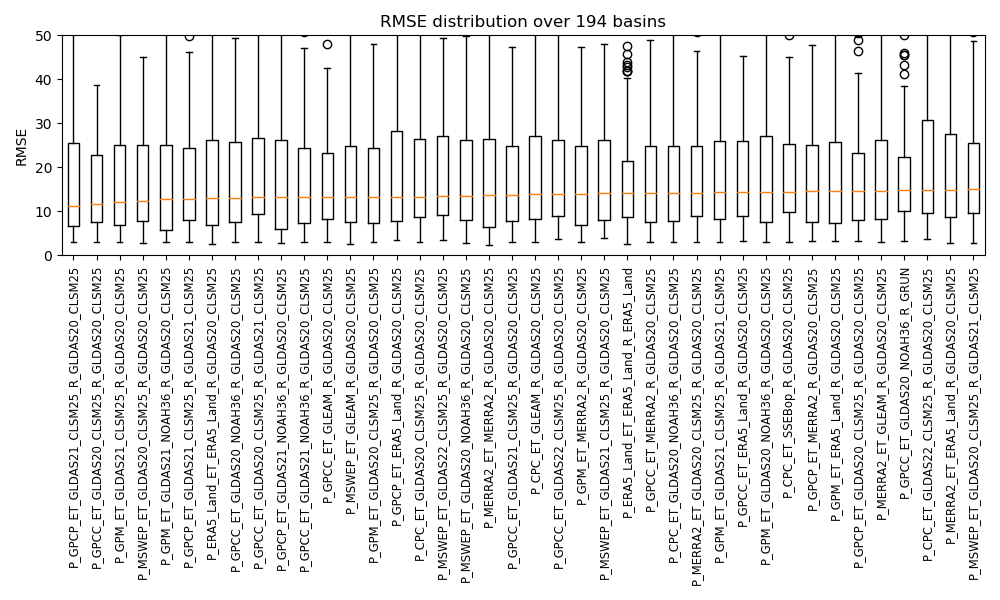

In [20]:
list_RMSE_wot_nan=[]
for dataset in datasets_sorted:
    temp=RMSE_tab[dataset].values
    list_RMSE_wot_nan.append(temp[~np.isnan(temp)])
    
plt.figure(figsize=(10,6))
plt.boxplot(list_RMSE_wot_nan)
plt.xticks(np.arange(1,datasets_sorted.shape[0]+1),datasets_sorted.str[:-22],rotation=90,fontsize='small')
plt.ylabel('RMSE')
plt.title('RMSE distribution over {} basins'.format(RMSE_tab.shape[0]))
plt.ylim([0,50])
plt.tight_layout()
plt.show()

## Tables of performances per hydrological variable

In [21]:
def findnth(haystack, needle, n):
    parts= haystack.split(needle, n+1)
    if len(parts)<=n+1:
        return -1
    return len(haystack)-len(parts[-1])-len(needle)

In [22]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    #return ['background-color: yellow' if v else '' for v in is_max]
    return ['font-weight: bold' if v else '' for v in is_min]

Tables of RMSE distribution and percentage of basins in each performance category for all datasets

In [28]:
hydro_var_name='P'
method='all' # 'best' to compute percentage over the best combination, 'all' to compute over all combinations
climate='all'
#climate=[16] # 'all' to include all basins or a list between 1 and 18 to restrict to a given climate zone


if hydro_var_name=='P':
    list_data=pd.Index(np.unique(data_P)).str[len(hydro_var_name)+1:]
if hydro_var_name=='ET':
    list_data=pd.Index(np.unique(data_ET)).str[len(hydro_var_name)+1:]
if hydro_var_name=='R':
    list_data=pd.Index(np.unique(data_R)).str[len(hydro_var_name)+1:]

stats=pd.DataFrame(np.zeros((list_data.shape[0],4)),index=list_data,
                   columns=['median','1st quartile','3rd quartile','% missing values'])

for data in list_data:
    select_datasets=[i for i in datasets if '{}_{}'.format(hydro_var_name,data) in i]
    
    if climate=='all':
        select_RMSE_tab=RMSE_tab[select_datasets]
    else:
        select_RMSE_tab=RMSE_tab.loc[basins['CLIMATE'].isin(climate),select_datasets]
    #print('You selected {} basins'.format(select_NSE_tab.shape[0]))
    temp=select_RMSE_tab.values.flatten()
    (nb_basins,nb_datasets)=select_RMSE_tab.shape
    
    # do we want percentages over all basins or non-missing values ?
    #nb_nan=np.sum(np.isnan(temp))
    nb_nan=0
    
    stats.loc[data,'% missing values']=100*np.sum(np.isnan(temp))/temp.shape[0]
    
    temp=temp[~np.isnan(temp)]
    stats.loc[data,'median']=np.median(temp)
    stats.loc[data,'1st quartile']=np.percentile(temp, 25, interpolation = 'midpoint') 
    stats.loc[data,'3rd quartile']=np.percentile(temp, 75, interpolation = 'midpoint') 
    

stats.style.apply(highlight_min)

,median,1st quartile,3rd quartile,% missing values
CPC,21.455528,12.156033,38.975839,29.909794
CRU,26.838947,16.510994,43.080372,30.210481
ERA5_Land,20.429069,11.700474,33.628505,29.909794
GPCC,18.975577,11.227965,32.724529,29.987113
GPCP,19.928287,11.191548,32.782231,29.909794
GPM,19.833070,10.815015,33.402686,36.576460
MERRA2,20.405081,11.969367,35.654801,29.948454
MSWEP,19.823784,11.199332,33.645020,33.324742
TRMM,32.010319,21.605802,42.527044,93.191581


Format latex tab with optimal values in bold

In [29]:
str_latex=stats.to_latex(float_format="%.2f")
columns_descr='{} & \\thead{median} & \\thead{1st quartile} &  \\thead{3rd quartile} &'
columns_descr+='\\thead{ \\% missing basins }'
str_latex=str_latex[:str_latex.find('\\toprule')+9]+columns_descr+str_latex[str_latex.find('\\midrule'):]

for i,col in enumerate(stats.columns[:-1]):
    best_dataset=stats.index[stats[col].argmin()]
    
    ind=str_latex.find(best_dataset.replace('_','\_'))
    first_sep=findnth(str_latex[ind:],'&',i)+ind
    second_sep=findnth(str_latex[ind:],'&',i+1)+ind
    
    #print(best_dataset,first_sep,second_sep)
    
    #first_sep=str_latex.find('&',ind)
    #second_sep=str_latex.find('&',first_sep+1)
    
    str_latex=str_latex[:first_sep+1]+'\\textbf {'+str_latex[first_sep+1:second_sep].replace(" ", "") +'}'+str_latex[second_sep:]

# format datasets names
str_latex=str_latex.replace('\_',' ')
str_latex=str_latex.replace('GLDAS20','GLDAS2.0')
str_latex=str_latex.replace('GLDAS21','GLDAS2.1')
str_latex=str_latex.replace('GLDAS22','GLDAS2.2')

str_latex=str_latex.replace('CLSM25','CLSM2.5')
str_latex=str_latex.replace('NOAH36','NOAH3.6')
str_latex=str_latex.replace('VIC412','VIC4.1.2')

str_latex='\\resizebox{ \\textwidth}{!}{' + str_latex[:-1] + '}'

print(str_latex)

\resizebox{ \textwidth}{!}{\begin{tabular}{lrrrr}
\toprule
{} & \thead{median} & \thead{1st quartile} &  \thead{3rd quartile} &\thead{ \% missing basins }\midrule
CPC       &   21.46 &         12.16 &         38.98 &             29.91 \\
CRU       &   26.84 &         16.51 &         43.08 &             30.21 \\
ERA5 Land &   20.43 &         11.70 &         33.63 &             29.91 \\
GPCC      &\textbf {18.98}&         11.23 &\textbf {32.72}&             29.99 \\
GPCP      &   19.93 &         11.19 &         32.78 &             29.91 \\
GPM       &   19.83 &\textbf {10.82}&         33.40 &             36.58 \\
MERRA2    &   20.41 &         11.97 &         35.65 &             29.95 \\
MSWEP     &   19.82 &         11.20 &         33.65 &             33.32 \\
TRMM      &   32.01 &         21.61 &         42.53 &             93.19 \\
\bottomrule
\end{tabular}}
